In [1]:
%matplotlib inline 

import six
import Quandl
import calendar
import numpy as np
import pandas as pd
import seaborn as sb  
import pylab as pylab
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
import statsmodels.stats.stattools as stats_stattools
import statsmodels.tsa.stattools as tsa_stattools
import statsmodels.tsa.seasonal as tsa_seasonal

import xgboost as xgb
from unbalanced_dataset import SMOTE

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectFromModel

import sys
from os import listdir
from os.path import isfile, join
from helpers import correlation, procces_stocks, data_manipulation, download_quandl_data, ml_dataset
from classes import Iteration

fig_size = [10, 6]
plt.rcParams["figure.figsize"] = fig_size
sb.set_style('darkgrid')


## # Feature selection
#clf = ExtraTreesClassifier(random_state=1729, n_jobs=-1)
#selector = clf.fit(trainX, trainY)
#fs = SelectFromModel(selector, prefit=True)
## clf.feature_importances_ 
#
#trainX = fs.transform(trainX)
#test = fs.transform(test)

In [11]:
GOLD = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
SILVER = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
PLAT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
INDEX_DJIA = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
INDEX_HSI = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
INDEX_IBEX = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
INDEX_N225 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
INDEX_SP500 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')
values_names = ['GOLD', 'SILVER', 'PLAT', 'INDEX_DJIA', 'INDEX_HSI', 'INDEX_IBEX', 'INDEX_N225', 'INDEX_SP500']
values_dfs = [GOLD, SILVER, PLAT, INDEX_DJIA, INDEX_HSI, INDEX_IBEX, INDEX_N225, INDEX_SP500]
values_cols = ['USD (AM)', 'USD', 'USD AM', 'Close', 'Close', 'Close', 'Close', 'Close']
values = [GOLD['USD (AM)'], SILVER['USD'], PLAT['USD AM'], INDEX_DJIA['Close'], INDEX_HSI['Close'], INDEX_IBEX['Close'], INDEX_N225['Close'], INDEX_SP500['Close']]

values_cols_b = ['DIFF_B', 'DIFF_B', 'DIFF_B', 'DIFF_B', 'DIFF_B', 'DIFF_B', 'DIFF_B', 'DIFF_B']
#values_cols = ['DIFF', 'DIFF', 'DIFF', 'DIFF', 'DIFF', 'DIFF', 'DIFF', 'DIFF']

dataset = ml_dataset.generate_df_dataset(values_names, values_dfs, values_cols)
dataset_b = ml_dataset.generate_df_dataset(values_names, values_dfs, values_cols_b)

In [18]:
train_index = []
test_index = []
for i in range(dataset.shape[0]):
    if i % 30 == 0 and i > 0:
        test_index.append(i)
    else:
        train_index.append(i)

train_df = dataset.ix[train_index]        
test_df = dataset.ix[test_index]        
train_df_b = dataset_b.ix[train_index]        
test_df_b = dataset_b.ix[test_index]        

In [8]:
iterations = []

iteration_train_dates1 = Iteration.Iteration('1993-07-07', '1997-07-07')
iterations.append(iteration_train_dates1)
iteration_test_dates1  = Iteration.Iteration('1997-07-08', '1998-07-07')
iterations.append(iteration_test_dates1)
iteration_train_dates2 = Iteration.Iteration('1998-07-08', '2002-07-08')
iterations.append(iteration_train_dates2)
iteration_test_dates2  = Iteration.Iteration('2002-07-05', '2003-07-07')
iterations.append(iteration_test_dates2)
iteration_train_dates3 = Iteration.Iteration('2003-07-08', '2007-07-06')
iterations.append(iteration_train_dates3)
iteration_test_dates3  = Iteration.Iteration('2007-07-09', '2008-07-07')
iterations.append(iteration_test_dates3)
iteration_train_dates4 = Iteration.Iteration('2008-07-08', '2012-07-09')
iterations.append(iteration_train_dates4)
iteration_test_dates4  = Iteration.Iteration('2012-07-06', '2013-07-05')
iterations.append(iteration_test_dates4)
iteration_train_dates5 = Iteration.Iteration('2013-07-05', '2015-07-08')
iterations.append(iteration_train_dates5)
iteration_test_dates5  = Iteration.Iteration('2015-07-08', '2016-04-20')
iterations.append(iteration_test_dates5)

iteration_train_dates1.calculate_indices(dataset)
iteration_test_dates1.calculate_indices(dataset)
iteration_train_dates2.calculate_indices(dataset)
iteration_test_dates2.calculate_indices(dataset)
iteration_train_dates3.calculate_indices(dataset)
iteration_test_dates3.calculate_indices(dataset)
iteration_train_dates4.calculate_indices(dataset)
iteration_test_dates4.calculate_indices(dataset)
iteration_train_dates5.calculate_indices(dataset)
iteration_test_dates5.calculate_indices(dataset)

In [12]:
colsToRemove = ['Date', 'INDEX_IBEX']
colY = 'INDEX_IBEX'

for i in range(0, len(iterations), 2):
    print("===========================")    
    print("Iteration %s" % (i))
    print("Training: from %s to %s" % (iterations[i].startDate, iterations[i].endDate))
    print("Testing: from %s to %s" % (iterations[i+1].startDate, iterations[i+1].endDate))    
    trainDates = []
    testDates = []
    trainDates.append(iterations[i].lowerIndex)
    trainDates.append(iterations[i].upperIndex)
    testDates.append(iterations[i+1].lowerIndex)
    testDates.append(iterations[i+1].upperIndex)
    
    trainX, trainY, testX, testY = ml_dataset.dataset_to_train(dataset, dataset_b, trainDates, testDates, colsToRemove, colY, )
    
    ## SVM
    scv = svm.SVC(kernel='rbf')
    scv.fit(trainX, trainY)
    
    print scv.score(testX, testY)
    print classification_report(testY, scv.predict(testX))
    print roc_auc_score(testY, scv.predict(testX))


Iteration 0
Training: from 1993-07-07 to 1997-07-07
Testing: from 1997-07-08 to 1998-07-07
0.665338645418
             precision    recall  f1-score   support

         -1       0.63      0.59      0.61       111
          1       0.69      0.73      0.71       140

avg / total       0.66      0.67      0.66       251

0.657078507079
Iteration 2
Training: from 1998-07-08 to 2002-07-08
Testing: from 2002-07-05 to 2003-07-07
0.611111111111
             precision    recall  f1-score   support

         -1       0.61      0.59      0.60       124
          1       0.61      0.63      0.62       128

avg / total       0.61      0.61      0.61       252

0.61076108871
Iteration 4
Training: from 2003-07-08 to 2007-07-06
Testing: from 2007-07-09 to 2008-07-07
0.613545816733
             precision    recall  f1-score   support

         -1       0.67      0.50      0.57       130
          1       0.58      0.74      0.65       121

avg / total       0.63      0.61      0.61       251

0.617768

In [ ]:
colsX = ['Date', 'GOLD', 'SILVER', 'PLAT', 'INDEX_DJIA', 'INDEX_HSI', 'INDEX_N225', 'INDEX_SP500', 'INDEX_IBEX']
colsY = ['Date', 'INDEX_IBEX']
colsToRemove = ['Date', 'INDEX_IBEX']
trainX = np.nan_to_num(np.asarray(train_df.drop(colsToRemove, axis = 1)))
trainY = np.nan_to_num(np.asarray(train_df_b['INDEX_IBEX']))#, dtype="|S6"))
testX = np.nan_to_num(np.asarray(test_df.drop(colsToRemove, axis = 1)))
testY = np.nan_to_num(np.asarray(test_df_b['INDEX_IBEX']))#, dtype="|S6"))

In [40]:
## RBF
rbf = RandomForestClassifier(100)
rbf.fit(trainX, trainY)
## SVM
scv = svm.SVC(kernel='rbf')
scv.fit(trainX, trainY)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
print scv.score(testX, testY)
print classification_report(testY, scv.predict(testX))
print roc_auc_score(testY, scv.predict(testX))

print rbf.score(testX, testY)
print classification_report(testY, rbf.predict(testX))
print roc_auc_score(testY, rbf.predict(testX))

0.552702702703
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       331
          1       0.55      1.00      0.71       409

avg / total       0.31      0.55      0.39       740

0.5
0.535135135135
             precision    recall  f1-score   support

          0       0.47      0.28      0.35       331
          1       0.56      0.74      0.64       409

avg / total       0.52      0.54      0.51       740

0.510610951477


In [42]:
preds = scv.predict(testX)
good = []
bad = []
for sample in range(testY.shape[0]):
    #print("X %s - Y %s" % (testY[sample], preds[sample]))
    if testY[sample] == preds[sample]:
        good.append(10)
        bad.append(0)        
    else:
        bad.append(-10)
        good.append(0)

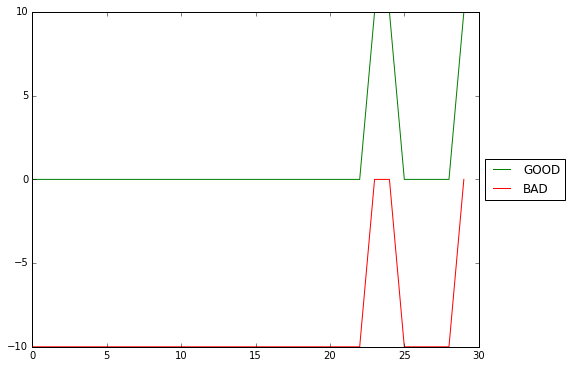

In [24]:
## PRICE FLOW BETWEEN TWO CONSECUTIVES DAYS ##
slice = 30
pylab.figure(1)

ax = plt.subplot(111)

ax.plot(good[:slice], 'g', label='GOOD')
ax.plot(bad[:slice], 'r', label='BAD')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [13]:
m2_xgb = xgb.XGBClassifier(n_estimators=110, nthread=-1, seed=1729)
m2_xgb.fit(trainX, trainY, eval_metric="auc", verbose = False, eval_set=[(testX, testY)])

# calculate the auc score
print("Roc AUC: ", roc_auc_score(testY, m2_xgb.predict_proba(testX)[:,1], average='macro'))

('Roc AUC: ', 0.49467051758396796)


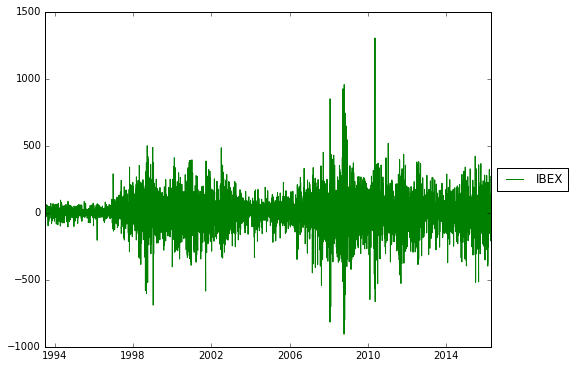

In [84]:
pylab.figure(1)

ax = plt.subplot(111)
x = [datetime.strptime(d,'%Y-%m-%d').date() for d in dataset['Date'].tolist()]
ax.plot(x, dataset['INDEX_IBEX'], 'g', label='IBEX')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [12]:
#data_manipulation.write_csv_data(GOLD_new, '/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
#data_manipulation.write_csv_data(SILVER_new, '/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
#data_manipulation.write_csv_data(PLAT_new, '/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
#data_manipulation.write_csv_data(INDEX_DJIA_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
#data_manipulation.write_csv_data(INDEX_HSI_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
#data_manipulation.write_csv_data(INDEX_IBEX_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
#data_manipulation.write_csv_data(INDEX_N225_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
#data_manipulation.write_csv_data(INDEX_SP500_new, '/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')